In [1]:
mat_file = '/media/data/Sophie/Microscopie/drosophila_fused.mat'


In [2]:
from scipy.io import loadmat
import ipyvolume as ipv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import Voronoi
from tyssue import Epithelium, BulkGeometry, config
from tyssue.generation import from_3d_voronoi, single_cell
from tyssue.draw import sheet_view

%matplotlib inline


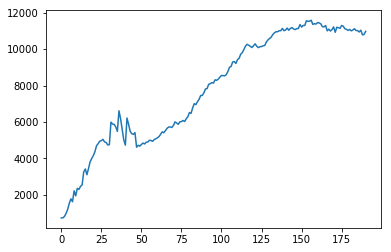

In [3]:
mat_db = loadmat(mat_file)
embryo = mat_db['embryo']
n_nuc = np.array([em[0].shape[0] for em in embryo])

fig, ax = plt.subplots()

ax.plot(n_nuc)

In [4]:
frame = 10

nuclei = (embryo[frame][0] - embryo[frame][0].mean(axis=0)[np.newaxis, :])[:, :3]
s, u, v = np.linalg.svd(nuclei)
nuclei = np.dot(nuclei, v.T)

ipv.clear()
ipv.scatter(x=nuclei[:, 0],
            y=nuclei[:, 1],
            z=nuclei[:, 2],
            size=0.5,
            marker='sphere')
ipv.xyzlim(-700, 700)
ipv.show()



In [7]:
centers[['x', 'y', 'z']].head()

,x,y,z
0,80.572556,126.053101,-542.126038
1,35.749638,258.621704,37.653030
2,264.182739,-24.815388,-199.798203
3,225.751053,-33.792004,-367.799438
4,204.805725,40.540703,487.680450


In [10]:
np.ptp(centers[['x', 'y', 'z']].values, axis=0)

array([ 559.0358 ,  550.38464, 1359.9974 ], dtype=float32)

In [ ]:
np.ptp()

In [13]:

centers = pd.DataFrame(nuclei, columns=list('zxy'))
centers['theta'] = 0.
centers['phi'] = 0.
a, b, c = np.ptp(centers[['x', 'y', 'z']].values, axis=0)

centers = centers.append(pd.Series(
    {'x':0, 'y':0, 'z':0,
     'theta':0, 'phi':0,}),
     ignore_index=True)

centers['x'] /= a
centers['y'] /= b
centers['z'] /= c

vor3d = Voronoi(centers[list('xyz')].values)
vor3d.close()
dsets = from_3d_voronoi(vor3d)


veptm = Epithelium('v', dsets, config.geometry.bulk_spec())
eptm = single_cell(veptm, veptm.cell_df.shape[0]-1)

eptm.vert_df['rho'] = np.linalg.norm(eptm.vert_df[eptm.coords], axis=1)
eptm.vert_df['theta'] = np.arcsin(eptm.vert_df.eval('z/rho'))
eptm.vert_df['phi'] = np.arctan2(eptm.vert_df['y'], eptm.vert_df['x'])

eptm.vert_df['x'] = a * (np.cos(eptm.vert_df['theta'])
                         * np.cos(eptm.vert_df['phi']))
eptm.vert_df['y'] = b * (np.cos(eptm.vert_df['theta'])
                         * np.sin(eptm.vert_df['phi']))
eptm.vert_df['z'] = c * np.sin(eptm.vert_df['theta'])
eptm.settings['abc'] = [a, b, c]
BulkGeometry.update_all(eptm)


In [12]:
np.sum?

In [14]:
ipv.clear()
fig, meshes = sheet_view(eptm, mode='3D', coords=['z', 'x', 'y'])

fig

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [82]:
veptm.edge_df['cell']

array([   0,    1,    2, ..., 5884, 5885, 5886])